In [280]:
%matplotlib inline
import numpy as np
from numpy import*
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy import interpolate
from matplotlib import colors as mcolors

from scipy.special import factorial
from scipy import fftpack
from skimage import io
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from scipy import signal
import scipy.ndimage as nd
from IPython.display import display, Markdown, Latex
import csv
import random
import glob
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap

In [166]:
random.random()

0.9291434537844883

In [209]:

def load_dataset(filename, train_size, y_col, features=None):
    with open(filename, 'r') as csvfile:
        lines = csv.reader(csvfile)
        x_train = []
        x_test = []
        y_train = []
        y_test = []
        for items in lines:
            
            if len(items)>1:
                y_val  = items[y_col]
                items.pop(y_col)
                if features is None:
                    items = np.array([float(item) for item in items])
                else:
                    items = np.array([float(items[i_feature]) for i_feature in features])
                if random.random() < train_size:
                    y_train.append(y_val)
                    x_train.append(items)
                else:
                    y_test.append(y_val)
                    x_test.append(items)
    return x_train, x_test, y_train, y_test

def get_dist(instance1, instance2):
    
    return np.linalg.norm(instance1-instance2)

import operator 
def get_neighs(xs_train, ys_train, x, k):
    distances = []
    
    for y_train, x_train in zip(ys_train, xs_train):
        dist = get_dist(x, x_train, )
        distances.append((y_train, dist))
    distances.sort(key=operator.itemgetter(1))
    neighbors = []
    for i in range(k):
        neighbors.append(distances[i][0])
    return neighbors

def get_best(neighs):
    unique, counts = np.unique(neighs, return_counts=True)
    best_id = np.argsort(counts)[::-1][0]
    best = unique[best_id]
    return best

In [205]:
def check_correct(xs_train, ys_train, x, y, k):
  
    neighs = get_neighs(xs_train, ys_train, x, k)
    y_pred = get_best(neighs)
    return 1 if y_pred==y else 0

def get_acc(xs_train, xs_test, ys_train, ys_test, k):
    correct = 0
    for x, y in zip(xs_test, ys_test):
        result = check_correct(xs_train, ys_train, x, y, k)
        correct += result
    return correct/(len(ys_test))*100


In [219]:

from multiprocessing import Pool 
train_size = .2
y_col = 4


n_exp =100
ks = range(1, 5, 1)
accs_by_k=[]
accs_by_k_std=[]

for k in ks:
    def thread_get_acc(i_exp):
        xs_train, xs_test, ys_train, ys_test = load_dataset(
            "iris.data.csv", 
            features=[2], 
            train_size=train_size, 
            y_col=y_col)
        return get_acc(xs_train, xs_test, ys_train, ys_test, k)
    pool = Pool()
    accs = pool.map(thread_get_acc, range(n_exp))
    pool.close() 
    pool.join()

    accs_by_k.append(np.mean(accs))
    accs_by_k_std.append(np.std(accs))


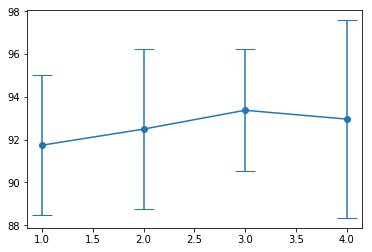

In [220]:
plt.figure()

plt.errorbar(
    ks, 
    accs_by_k, 
    yerr=accs_by_k_std,
    marker="o",
    capsize=10,
)
plt.show()

In [289]:
train_size = .2
y_col = 4
k=10
xs_train, xs_test, ys_train, ys_test = load_dataset(
            "iris.data.csv", 
            features=[2, 0], 
            train_size=train_size, 
            y_col=y_col)

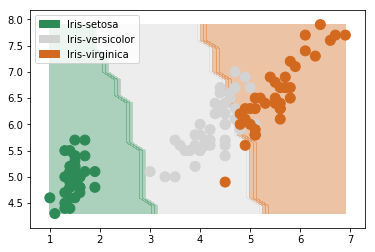

In [297]:
classes = np.unique(ys_test).tolist()
colors = np.random.choice(list(mcolors.CSS4_COLORS.keys()), size=len(classes), replace=False)
cm = LinearSegmentedColormap.from_list(
        'my_list', colors, N=len(classes))
n_points=25
id_x = 0
id_y = 1
xs = [x[id_x] for x in  xs_test]
ys = [x[id_y] for x in xs_test]
cs = [colors[classes.index(y)] for y in ys_test]
xs_back = np.linspace(np.min(xs), np.max(xs), n_points)
ys_back = np.linspace(np.min(ys), np.max(ys), n_points)
xs_back, ys_back = np.meshgrid(xs_back, ys_back)
def get_zs_back(x, y):
    zs_back = np.zeros_like(x)
    
    for i in range(n_points):
        for j in range(n_points):
            neighs = get_neighs(xs_train, ys_train, np.array([x[i,j], y[i,j]]), k)
            y_pred = get_best(neighs)
            zs_back[i, j] = classes.index(y_pred)
    return zs_back


zs_back = get_zs_back(xs_back, ys_back)            
plt.contourf(xs_back, ys_back, zs_back, alpha=0.4, cmap=cm)
plt.scatter(
    xs,
    ys,
    c=cs,
    s=100
)


legends = [
   mpatches.Patch(color=color, label=classe)
    for color, classe in zip(colors, classes)
] 
plt.legend(handles=legends)